---
# Comparison HRF in pRFpy

This notebook aims to assess the effects of the HRF chosen in pRFpy and custom HRFs such as `linescanning.glm.double_gamma`. Previously we already performed a grid fit on the functional data, described in `linescanning/notebooks/prf_partialfov.ipynb`. We load those parameters in the class `modelling2`, and perform a separate fit using a custom HRF in the `modelling`-class. This results in two sets of separate fits on the same data, which are then compared.

Goals:
- Optimize class `linescanning.prf.pRFmodelFitting` usage (e.g., loading + fitting + saving)
- Adapt pRFpy code to accept 1D numpy arrays as custom HRF (`prfpy.model line 194`)
- Compare fits with `pRFpy HRF` and `double gamma HRF` from linescanning.glm.double_gamma

In [13]:
%reload_ext autoreload
%autoreload 2

from linescanning import utils,glm,prf
import numpy as np
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from nilearn import signal
from nilearn.glm.first_level.design_matrix import _cosine_drift as dct_set
import os
import seaborn as sns
from scipy.io import loadmat
import warnings
warnings.simplefilter('ignore')

opj = os.path.join
base, place = utils.get_base_dir()

base_dir = opj(base, 'projects', 'hemifield')
fig_dir = opj(base_dir, 'code', 'figures', 'prf')
task_dir = "/data1/projects/MicroFunc/Jurjen/projects/hemifield/sourcedata/sub-003/ses-3/task/sub-003_ses-3_run-1_task-PRF"
func_dir = "/data1/projects/MicroFunc/Jurjen/projects/hemifield/testing/partial_fov_prf"

### Fetch the onsets of pRF-experiment

In [2]:
# load onsets
onsets = utils.ParseExpToolsFile(utils.get_file_from_substring(".tsv", task_dir), TR=1.111508, delete_vols=0)
trial_df = onsets.get_onset_df()
print(trial_df.head(10))
print(f"TR = {onsets.TR}")

       onset  event_type  subject  run
0  24.027787  horizontal        1    1
1  24.335912  horizontal        1    1
2  24.648357  horizontal        1    1
3  24.967799  horizontal        1    1
4  25.273364  horizontal        1    1
5  25.592802  horizontal        1    1
6  25.912251  horizontal        1    1
7  26.230947  horizontal        1    1
8  26.547622  horizontal        1    1
9  26.856028  horizontal        1    1
TR = 1.111508


### Fetch the functional data; apply high-pass filter + zscore data

Load data, apply highpass filtering in the form of discrete cosine set

(314134, 200)
(314134, 200)


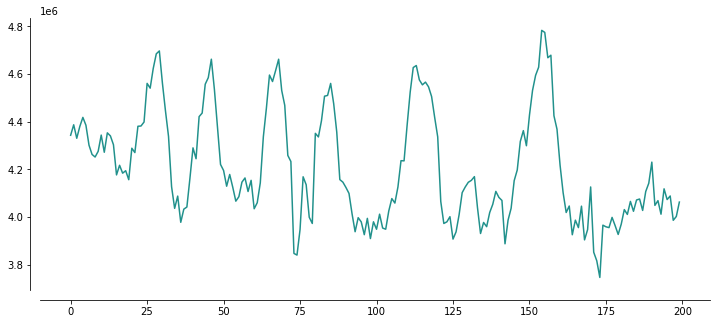

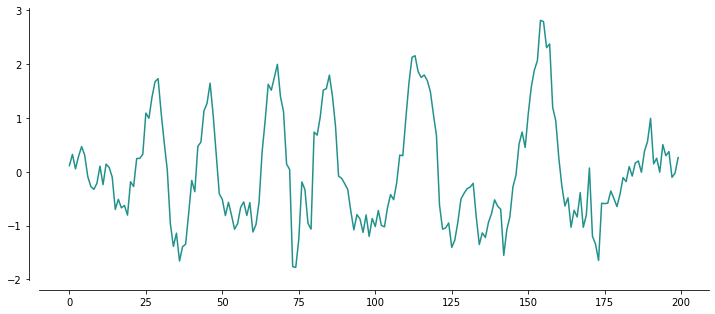

In [3]:
# load functional data
func_data = np.load(utils.get_file_from_substring("sub-003_ses-3_task-pRF_hemi-LR_space-fsnative_run-2_bold.func.npy", func_dir))

print(func_data.shape)

lb=0.01
n_vol = func_data.shape[-1]
st_ref = 0  # offset frametimes by st_ref * tr

# define discrete cosine
ft = np.linspace(st_ref * onsets.TR, (n_vol + st_ref) * onsets.TR, n_vol, endpoint=False)
hp_set = dct_set(lb, ft)
func_cleaned = signal.clean(func_data.T, detrend=False, standardize='zscore', confounds=hp_set).T

print(func_cleaned.shape)

glm.plot_array(func_data[336,...])
glm.plot_array(func_cleaned[336,...])

### Create design matrix for partial FOV experiment

Here, I chose to select the image in the middle of a given TR. This is because every TR the bar would move 4-5 places (TR = 1.1s, bar duration = 0.25s). So I loop through the TRs, add 0.5*TR, and find the closest value of that in the onset file of the experiment. You can then load in the appropriate screenshot based on the trial number that's coupled to the onset time. (see also `linescanning/notebooks/prf_partialfov.ipynb`)

In [6]:
screenshot_dir = opj(task_dir, "sub-003_ses-3_run-1_task-PRF_Screenshots")
image_list = os.listdir(screenshot_dir)
sorted(image_list)[:10]

n_pix = 270
design_matrix = np.zeros((n_pix, n_pix, func_data.shape[-1]))

for tr in range(func_data.shape[-1]):
    
    # find time at the middle of TR
    tr_in_sec = (tr * onsets.TR)+0.5*onsets.TR
    ix,tr_in_onset = utils.find_nearest(trial_df['onset'].values, tr_in_sec)
    
    # zero-pad number
    if ix > 1:
        img_number = str(ix-1).zfill(3)
    else:
        img_number = "001"

    image_file = utils.get_file_from_substring(img_number, screenshot_dir)
    
    if image_file != None:

        img = (255*mpimg.imread(image_file)).astype('int')

        if img.shape[0] != img.shape[1]:
            offset = int((img.shape[1]-img.shape[0])/2)
            img = img[:, offset:(offset+img.shape[0])]

        # downsample
        downsampling_constant = int(img.shape[1]/n_pix)
        downsampled_img = img[::downsampling_constant, ::downsampling_constant]

        if downsampled_img[:, :, 0].shape != design_matrix[..., 0].shape:
            print("please choose a n_pix value that is a divisor of " +
                  str(img.shape[0]))

        # binarize image into dm matrix
        # assumes: standard RGB255 format; only colors present in image are black, white, grey, red, green.
        design_matrix[:, :, tr][np.where(((downsampled_img[:, :, 0] == 0) & (
            downsampled_img[:, :, 1] == 0)) | ((downsampled_img[:, :, 0] == 255) & (downsampled_img[:, :, 1] == 255)))] = 1

In [7]:
gii_file = utils.get_file_from_substring("sub-003_ses-3_task-pRF_hemi-L_space-fsnative_run-3_bold.func.gii", func_dir)
print(gii_file)
gifti = utils.ParseGiftiFile(gii_file)
gifti.__dict__

/data1/projects/MicroFunc/Jurjen/projects/hemifield/testing/partial_fov_prf/sub-003_ses-3_task-pRF_hemi-L_space-fsnative_run-3_bold.func.gii


{'gifti_file': '/data1/projects/MicroFunc/Jurjen/projects/hemifield/testing/partial_fov_prf/sub-003_ses-3_task-pRF_hemi-L_space-fsnative_run-3_bold.func.gii',
 'f_gif': <nibabel.gifti.gifti.GiftiImage at 0x7fcd32f89270>,
 'data': array([[2690771.2, 2896243.2, 1578017.2, ...,       0. ,       0. ,
               0. ],
        [3120036.8, 3345314.2, 1911971.4, ...,       0. ,       0. ,
               0. ],
        [2900508.8, 3196758.8, 1880346.9, ...,       0. ,       0. ,
               0. ],
        ...,
        [2871641.5, 2796760.5, 2329286.2, ...,       0. ,       0. ,
               0. ],
        [2547122. , 2734521. , 2313736.5, ...,       0. ,       0. ,
               0. ],
        [2709133.2, 2874805.8, 2217690. , ...,       0. ,       0. ,
               0. ]], dtype=float32),
 'set_tr': None,
 'meta': {'TimeStep': '1111.0'},
 'TR_ms': 1111.0,
 'TR_sec': 1.111}

---
## pRF fitting

Load functional data

(314134, 200)
(314134, 200)


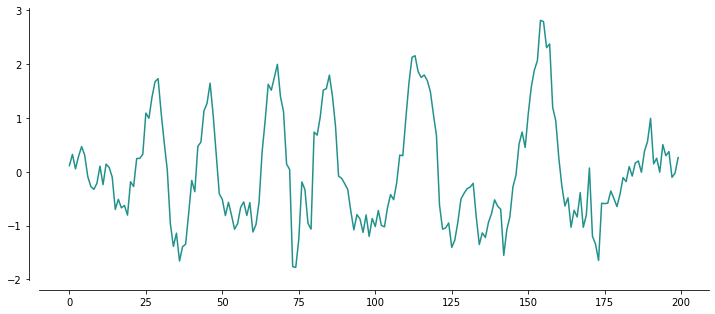

In [71]:
partial_fov_prf = opj(func_dir, "sub-003_ses-3_task-pRF_model-gauss_stage-grid_desc-prf_params.npy")
partial_fov_func = opj(func_dir, "sub-003_ses-3_task-pRF_hemi-LR_space-fsnative_run-2_bold.func.npy")
fn_settings = opj(func_dir, "20211224_model-gauss_desc-settings.yml")

# load functional data
func_data = np.load(partial_fov_func)

print(func_data.shape)

lb=0.01
n_vol = func_data.shape[-1]
st_ref = 0  # offset frametimes by st_ref * tr

# define discrete cosine
ft = np.linspace(st_ref * onsets.TR, (n_vol + st_ref) * onsets.TR, n_vol, endpoint=False)
hp_set = dct_set(lb, ft)
func_cleaned = signal.clean(func_data.T, detrend=False, standardize='zscore', confounds=hp_set).T

print(func_cleaned.shape)

glm.plot_array(func_cleaned[336,...])

Below we load in a previous pRF Gaussian grid fit with `hrf=None`, so that pRFpy creates its own HRFs

In [72]:
modelling2 = prf.pRFmodelFitting(func_cleaned,
                                 design_matrix=design_matrix,
                                 settings=fn_settings)

modelling2.load_params(partial_fov_prf, stage='grid')

Using settings file: /data1/projects/MicroFunc/Jurjen/projects/hemifield/testing/partial_fov_prf/20211224_model-gauss_desc-settings.yml


best voxel = 336; params = [  4.635 -14.266   1.434   0.012  -0.411   0.645]
In partial FOV experiment, pRF vox = 336


array([  4.635, -14.266,   1.434,   0.012,  -0.411,   0.645])

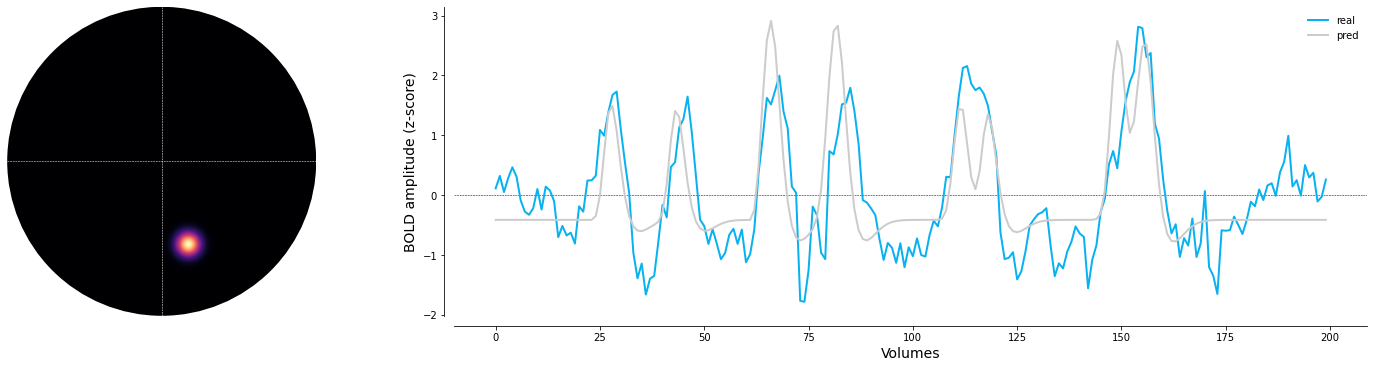

In [73]:
best_prf_idc = utils.find_max_val(modelling2.gauss_grid[...,-1])
vox = best_prf_idc[0]
params = modelling2.gauss_grid[best_prf_idc,...][0]
print(f"best voxel = {vox}; params = {params}")

print(f"In partial FOV experiment, pRF vox = {vox}")
modelling2.plot_vox(vox_nr=vox, stage='grid')

### Extract and compare HRFs

Here we extract the HRF used in the previous fit and construct our custom HRF using `linescanning.glm.double_gamma`, which is basically the HRF specified here: https://github.com/tknapen/brainimaging_VU/blob/main/notebooks/glm.ipynb.

We then plot them together, and we can see some differences already. The pRFpy-HRF is not normalized, and thus has a pretty small undershoot. I couldn't find anything in the pRFpy code about this..

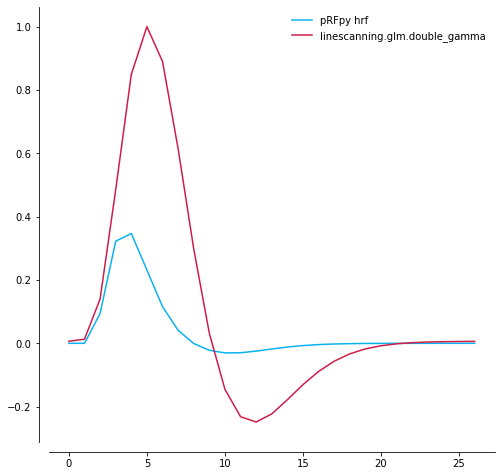

(1, 27)
(27,)
(1, 27)
1


In [74]:
dt = 1
time_points = np.linspace(0,27,np.rint(float(27)/dt).astype(int))
hrf_custom = glm.double_gamma(time_points, lag=6)

hrf_orig = modelling2.gaussian_model.hrf
glm.plot_array([hrf_orig.T, hrf_custom], figsize=(8,8), color=["#08B2F0", "#D01B47"], labels=["pRFpy hrf", "linescanning.glm.double_gamma"])

print(hrf_orig.shape)
print(hrf_custom.shape)

hrf_custom = hrf_custom[np.newaxis,...]
print(hrf_custom.shape)
print(len(hrf_custom))

fit model with custom HRF. I went into `prfpy.model` and added the following to line 194:
```python
elif isinstance(hrf, np.ndarray):
    self.hrf = hrf     
```

So that any `<1, timepoints>` numpy array is accepted by the code. Then I performed the fit as usual, but with `hrf=hrf_custom`

In [28]:
modelling = prf.pRFmodelFitting(func_cleaned, 
                                design_matrix=design_matrix, 
                                TR=gifti.TR_sec, 
                                model='gauss', 
                                stage='grid', 
                                verbose=True,
                                hrf=hrf_custom,
                                output_dir=func_dir,
                                output_base="sub-003_ses-3_task-pRF_hrf-custom",
                                write_files=True)

modelling.fit()

# params = modelling.gauss_grid
# output = "/data1/projects/MicroFunc/Jurjen/projects/hemifield/testing/partial_fov_prf/sub-003_ses-3_task-pRF_hrf-custom_model-gauss_stage-grid_desc-prf_params.npy"
# np.save(output, params)

Using settings file: /data1/projects/MicroFunc/Jurjen/projects/hemifield/testing/partial_fov_prf/20211224_model-gauss_desc-settings.yml
Starting gauss grid fit at 2021/12/24 12:51:17
Gaussian gridfit completed at 2021/12/24 13:23:24. voxels/vertices above 0.1: 4082 out of 314134
Gridfit took 0:32:07.039389
Mean rsq>0.1: 0.21784111455681568


This fit resulted in slightly fewer voxels surviving the `rsq_threshold=0.1`: `4115` (pRFpy HRF) vs `4082` (custom HRF)

With custom HRF, pRF vox = 336


array([  4.635, -14.266,   1.893,   0.002,  -0.337,   0.649])

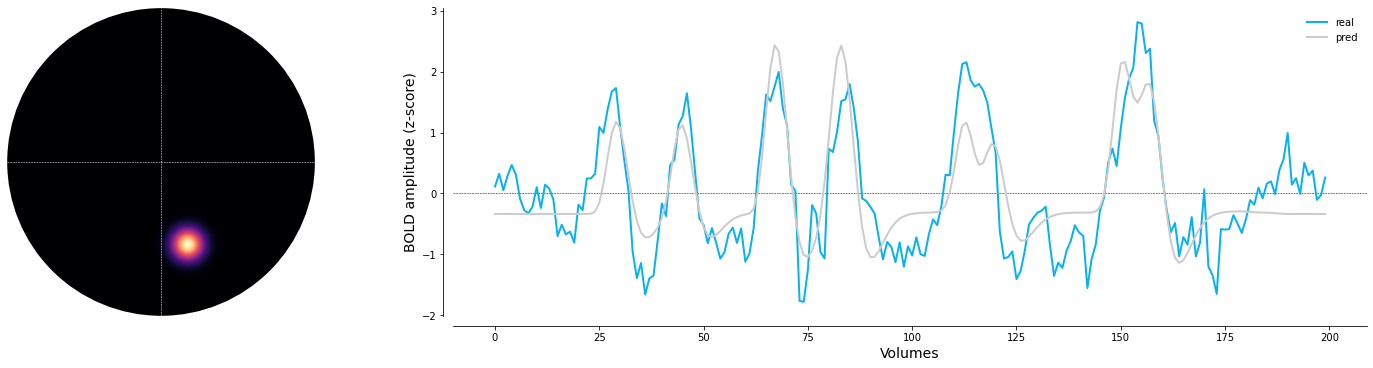

In [75]:
print(f"With custom HRF, pRF vox = {vox}")
modelling.plot_vox(vox_nr=vox, stage='grid')

This fit already resulted in a veeery (almost negligible) improvement of the fit: `0.645` (pRFpy HRF) vs `0.649` (custom HRF)

---
# Combine predictions

Below I plotted both predictions together with the data. In general, the custom HRF does a better job with the undershoot parts, but other than that not a lot of differences

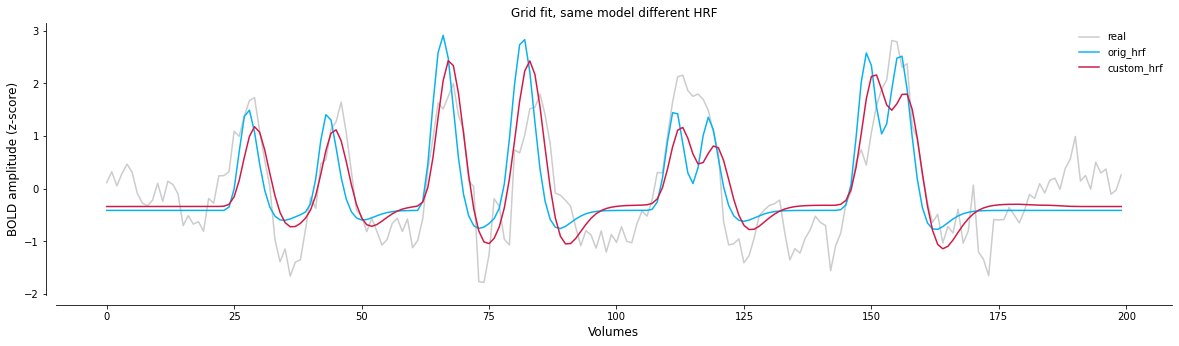

In [66]:
pred_orig_hrf = modelling2.prediction
pred_custom_hrf = modelling.prediction
vox_data = modelling.data[vox,...]

glm.plot_array([vox_data, pred_orig_hrf, pred_custom_hrf], color=["#cccccc", "#08B2F0", "#D01B47"], labels=['real', 'orig_hrf', 'custom_hrf'], figsize=(20,5), x_label="Volumes", y_label="BOLD amplitude (z-score)", title="Grid fit, same model different HRF")